In [151]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# --------------------------
# Data Loading Functions
# --------------------------
def generate_parameter_list(folder, L, rand_num, rand_max):
    parameters = []
    for i in range(rand_num):
        filename = f"{folder}/obs_L{L}_random_run{i}.csv"
        if os.path.exists(filename):
            parameters.append([L, i])
        if len(parameters) >= rand_max:
            break
    return parameters

def load_data(folder, parameters):
    all_kappa, all_f, all_gL = [], [], []
    all_R2, all_Rg2, all_Rxz = [], [], []
    all_Sq2D = []
    qB = None
    for L, run_num in parameters:
        filename = f"{folder}/obs_L{L}_random_run{run_num}.csv"
        if not os.path.exists(filename):
            continue
        data = np.genfromtxt(filename, delimiter=",", skip_header=1)
        # Extract polymer parameters
        kappa, f, g = data[0, 2:5]
        R2, Rg2, Rxz = data[0, 14], data[0, 15], data[0, 20]

        all_kappa.append(kappa)
        all_f.append(f)
        all_gL.append(g * L)

        all_R2.append(R2 / L**2)
        all_Rg2.append(Rg2 / L**2)
        all_Rxz.append(Rxz / Rg2)

        qB = data[3, 21:]
        Sq2D = data[7:, 21:]
        all_Sq2D.append(Sq2D)
    # Create the (N,3) params array and the (N,6) features (for later use)
    params = np.array([all_kappa, all_f, all_gL]).T  # shape: (N, 3)
    features = np.array([all_kappa, all_f, all_gL, all_R2, all_Rg2, all_Rxz]).T  # shape: (N, 6)
    features = params.copy()  # (N,3) params
    qB = np.array(qB)
    # Apply log-transform on images.
    images = -np.log(all_Sq2D)
    return params, features, images, qB

class ScatteringDataset(Dataset):
    def __init__(self, folder, parameters, transform=None, normalize_data=True, normalize_images=True):
        # Unpack raw data from load_data.
        raw_params, raw_features, raw_images, self.qB = load_data(folder, parameters)

        if normalize_data:
            # Normalize the (N,3) polymer parameters.
            self.param_mean = raw_params.mean(axis=0)
            self.param_std = raw_params.std(axis=0)
            param_norm = (raw_params - self.param_mean) / self.param_std

            # Normalize the (N,6) features.
            self.features_mean = raw_features.mean(axis=0)
            self.features_std = raw_features.std(axis=0)
            features_norm = (raw_features - self.features_mean) / self.features_std
        else:
            param_norm = raw_params
            features_norm = raw_features
            self.param_mean, self.param_std = None, None
            self.features_mean, self.features_std = None, None

        # Normalize images globally.
        if normalize_images:
            stacked = np.stack(raw_images, axis=0)  # shape: (N, H, W)
            self.images_mean = stacked.mean()
            self.images_std = stacked.std()
            images_norm = [(img - self.images_mean) / self.images_std for img in raw_images]
        else:
            images_norm = raw_images
            self.images_mean, self.images_std = None, None

        # Save the normalized arrays.
        self.params = param_norm      # (N, 3)
        self.features = features_norm  # (N, 6)
        self.images = images_norm      # list of (H, W) arrays
        self.transform = transform

    def __len__(self):
        return len(self.params)

    def __getitem__(self, idx):
        params = self.params[idx]        # (3,)
        feature = self.features[idx]     # (6,)
        image = self.images[idx]         # (H, W)
        if image.ndim == 2:
            image = image[np.newaxis, :, :]  # (1, H, W)
        params = torch.tensor(params, dtype=torch.float32)
        feature = torch.tensor(feature, dtype=torch.float32)
        image = torch.tensor(image, dtype=torch.float32)
        if self.transform:
            image = self.transform(image)
        return params, feature, image

def create_dataloader(folder, parameters, batch_size=32, shuffle=True, transform=None):
    dataset = ScatteringDataset(folder, parameters, transform=transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle), dataset

# --------------------------
# Model Definitions
# --------------------------
class Encoder(nn.Module):
    def __init__(self, latent_dim, nq):
        super(Encoder, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU()  # [B,1,nq,nq] -> [B,32,nq/2,nq/2] -> [B,64,nq/4,nq/4]
        )
        dummy = torch.zeros(1, 1, nq, nq)
        conv_out = self.conv(dummy)
        self.flatten_dim = conv_out.numel()
        self.fc_mu = nn.Linear(self.flatten_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_dim, latent_dim)

    def forward(self, x):
        batch_size = x.size(0)
        x = self.conv(x)
        x = x.view(batch_size, -1)
        return self.fc_mu(x), self.fc_logvar(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim, nq):
        super(Decoder, self).__init__()
        self.nq = nq
        dummy = torch.zeros(1, 1, nq, nq)
        conv_out = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )(dummy)
        self.channels = conv_out.size(1)
        self.height = conv_out.size(2)
        self.width = conv_out.size(3)
        self.flatten_dim = self.channels * self.height * self.width
        self.fc = nn.Linear(latent_dim, self.flatten_dim)
        self.deconv = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(self.channels, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
        )

    def forward(self, z):
        batch_size = z.size(0)
        x = self.fc(z)
        x = x.view(batch_size, self.channels, self.height, self.width)
        x = self.deconv(x)
        if x.shape[-1] != self.nq:
            x = F.interpolate(x, size=(self.nq, self.nq), mode="bilinear", align_corners=False)
        return x

class VAE(nn.Module):
    def __init__(self, latent_dim, nq):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim, nq)
        self.decoder = Decoder(latent_dim, nq)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

class ConverterP2L(nn.Module):
    def __init__(self, latent_dim):
        super(ConverterP2L, self).__init__()  # params to latent
        # Map params (size 3) to a hidden representation.
        self.shared = nn.Sequential(
            nn.Linear(3, 9),
            nn.BatchNorm1d(9),
            nn.Tanh(),
        )
        # Branch for μ and logvar.
        self.fc_mu = nn.Linear(9, latent_dim)
        self.fc_logvar = nn.Linear(9, latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, params):
        h = self.shared(params)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

class ConverterL2F(nn.Module):
    # Convert latent variables to the full set of (N,6) features.
    def __init__(self, latent_dim):
        super(ConverterL2F, self).__init__()  # latent to features
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 9),
            nn.BatchNorm1d(9),
            nn.Tanh(),
            nn.Linear(9, 3),  # output: (N,6) features
        )

    def forward(self, z):
        return self.fc(z)

# --------------------------
# Training Functions
# --------------------------
def train_vae(vae, dataloader, num_epochs=50, lr=1e-3, device="cpu"):
    optimizer = optim.Adam(vae.parameters(), lr=lr)
    vae.to(device)
    vae.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for _, _, images in dataloader:  # VAE training uses only images.
            images = images.to(device)
            optimizer.zero_grad()
            recon, mu, logvar = vae(images)
            recon_loss = F.mse_loss(recon, images, reduction="mean")
            loss = recon_loss  # (Optional KL loss term can be added)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"VAE Epoch {epoch+1}, Loss: {total_loss/len(dataloader.dataset):.6f}")

def train_converterP2L(converterP2L, decoder, dataloader, num_epochs=30, lr=1e-3, device="cpu"):
    """
    Train the ConverterP2L module to map polymer parameters to latent codes.
    The decoder is frozen and used to compute the image reconstruction loss.
    """
    # Freeze the decoder.
    decoder.to(device)
    for p in decoder.parameters():
        p.requires_grad = False
    decoder.eval()

    optimizer = optim.Adam(converterP2L.parameters(), lr=lr)
    converterP2L.to(device)
    converterP2L.train()

    for epoch in range(num_epochs):
        total_loss = 0
        for params, features, images in dataloader:
            params = params.to(device)
            images = images.to(device)
            optimizer.zero_grad()
            # Map polymer parameters (N,3) to latent space.
            z, mu, logvar = converterP2L(params)
            # Generate images using the frozen decoder.
            image_output = decoder(z)
            loss = F.mse_loss(image_output, images)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"[ConverterP2L] Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.6f}")

    # unfreeze the decoder after training
    for p in decoder.parameters():
        p.requires_grad = True
    decoder.train()


def train_converterL2F(encoder, converterL2F, dataloader, num_epochs=30, lr=1e-3, device="cpu"):
    """
    Train the ConverterL2F module to map latent codes to full features.
    The ConverterP2L module is frozen so that it provides a stable latent representation.
    """

    # freeze the vae
    encoder.to(device)
    for p in encoder.parameters():
        p.requires_grad = False
    encoder.eval()
    # Obtain latent representation from the encoder.
    # Freeze converterP2L.
    #converterP2L.to(device)
    #for p in converterP2L.parameters():
    #    p.requires_grad = False
    #converterP2L.eval()

    optimizer = optim.Adam(converterL2F.parameters(), lr=lr)
    converterL2F.to(device)
    converterL2F.train()

    for epoch in range(num_epochs):
        total_loss = 0
        for params, features, images in dataloader:
            params = params.to(device)
            features = features.to(device)
            optimizer.zero_grad()

            # Obtain latent representation from the frozen encoder
            images = images.to(device)
            mu, logvar = encoder(images)
            z = mu + torch.randn_like(mu) * torch.exp(0.5 * logvar)  # reparameterization
            # Map latent code to features.
            features_output = converterL2F(z)
            loss = F.mse_loss(features_output, features)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"[ConverterL2F] Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.6f}")

    # unfreeze converterP2L after training if further joint fine-tuning is desired.
    for p in encoder.parameters():
        p.requires_grad = True
    encoder.train()


def train_converter(converterP2L, decoder, converterL2F, dataloader, num_epochs=30, lr=1e-3, device="cpu"):
    # Freeze the decoder.
    decoder.to(device)
    for p in decoder.parameters():
        p.requires_grad = False
    decoder.eval()

    # Train converter and ConverterL2F jointly.
    params_list = list(converterP2L.parameters()) + list(converterL2F.parameters())
    optimizer = optim.Adam(params_list, lr=lr)
    converterP2L.to(device)
    converterL2F.to(device)
    converterP2L.train()
    converterL2F.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for params, features, images in dataloader:
            params = params.to(device)
            features = features.to(device)
            images = images.to(device)
            optimizer.zero_grad()
            # Map params (N,3) to latent space.
            z, mu, logvar = converterP2L(params)
            # Branch 1: generate image using the decoder.
            image_output = decoder(z)
            # Branch 2: generate full (N,6) features.
            features_output = converterL2F(z)
            image_loss = F.mse_loss(image_output, images)
            feature_loss = F.mse_loss(features_output, features)
            loss = image_loss + feature_loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"[Converter] Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.6f}")

    # Unfreeze the decoder after training
    for p in decoder.parameters():
        p.requires_grad = True
    decoder.train()



def train_end_to_end(encoder, decoder, converterP2L, converterL2F, dataloader, num_epochs=20, lr=1e-4, device="cpu"):
    """
    End-to-end fine-tuning of the entire network:
    encoder, decoder, converterP2L, and converterL2F are trained together.
    The combined loss includes:
      - VAE reconstruction loss (using the encoder & decoder)
      - Converter image loss (using converterP2L & decoder)
      - Converter feature loss (using converterP2L & converterL2F)
    """
    # Combine parameters from all modules.
    all_params = list(encoder.parameters()) + list(decoder.parameters()) + \
                 list(converterP2L.parameters()) + list(converterL2F.parameters())
    optimizer = optim.Adam(all_params, lr=lr)

    # Move all modules to device and set to train mode.
    encoder.to(device); decoder.to(device)
    converterP2L.to(device); converterL2F.to(device)
    encoder.train(); decoder.train()
    converterP2L.train(); converterL2F.train()

    for epoch in range(num_epochs):
        total_loss = 0
        for params, features, images in dataloader:
            params = params.to(device)
            features = features.to(device)
            images = images.to(device)
            optimizer.zero_grad()

            # VAE branch: Encode images and reconstruct.
            mu_enc, logvar_enc = encoder(images)
            z_enc = mu_enc + torch.randn_like(mu_enc) * torch.exp(0.5 * logvar_enc)  # reparameterization
            recon_images = decoder(z_enc)
            vae_loss = F.mse_loss(recon_images, images)

            # Converter branch: Map polymer params to latent space.
            z_conv, mu_conv, logvar_conv = converterP2L(params)
            conv_image = decoder(z_conv)
            conv_features = converterL2F(z_conv)
            conv_image_loss = F.mse_loss(conv_image, images)
            conv_feature_loss = F.mse_loss(conv_features, features)

            # Combined loss.
            loss = vae_loss + conv_image_loss + conv_feature_loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"End-to-End Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.6f}")


def generate_scattering(converterP2L, decoder, params, param_mean, param_std, images_mean, images_std, device="cpu", denormalize=True):
    """
    Given raw polymer params, normalize them using provided stats,
    pass through the converter and decoder, and then optionally denormalize the output image.
    """
    converterP2L.to(device)
    decoder.to(device)
    converterP2L.eval()
    decoder.eval()
    with torch.no_grad():
        #mean_tensor = torch.tensor(param_mean, dtype=torch.float32, device=device)
        #std_tensor = torch.tensor(param_std, dtype=torch.float32, device=device)
        #params_norm = (params.to(device) - mean_tensor) / std_tensor
        z, mu_conv, logvar_conv = converterP2L(params)
        norm_output = decoder(z)
        if denormalize:
            img_mean = torch.tensor(images_mean, dtype=torch.float32, device=device)
            img_std = torch.tensor(images_std, dtype=torch.float32, device=device)
            output = norm_output * img_std + img_mean
        else:
            output = norm_output
    return output


def infer_feature(encoder, converterL2F, images, images_mean, images_std, features_mean, features_std, device="cpu", denormalize=True):
    """
    Given raw images, this function normalizes them using the provided image stats,
    passes them through the encoder to obtain a latent representation, and then uses
    the ConverterL2F module to infer the full (N,6) features. The output features are then
    optionally denormalized using the provided feature stats.
    """
    encoder.to(device)
    converterL2F.to(device)
    encoder.eval()
    converterL2F.eval()
    with torch.no_grad():
        # Normalize images.
        #img_mean = torch.tensor(images_mean, dtype=torch.float32, device=device)
        #img_std = torch.tensor(images_std, dtype=torch.float32, device=device)
        #images_norm = (images.to(device) - img_mean) / img_std
        # Obtain latent representation using the encoder.
        mu, logvar = encoder(images)
        # For deterministic inference, we use mu as the latent code.
        z = mu
        # Convert latent code to normalized features.
        norm_features = converterL2F(z)
        if denormalize:
            f_mean = torch.tensor(features_mean, dtype=torch.float32, device=device)
            f_std = torch.tensor(features_std, dtype=torch.float32, device=device)
            features_out = norm_features * f_std + f_mean
        else:
            features_out = norm_features
    return features_out


In [ ]:
# folder = "../data/20240924_random"
folder = "../data/20250217"  # 64x64 data, with additional qb1d line
L = 200
rand_num = 5500
rand_max = 4500
parameters = generate_parameter_list(folder, L, rand_num, rand_max)

batch_size = 32
dataloader, dataset = create_dataloader(folder, parameters, batch_size=batch_size, shuffle=True)

# Automatically determine image size (nq) from the dataset.
# Note: __getitem__ returns (params, feature, image)
sample_params, sample_features, sample_images = next(iter(dataloader))
nq = sample_images.shape[-1]  # Assuming images are [B, 1, H, W] and square.
print("Detected image size:", nq, "x", nq)

# Set latent_dim to 3 so that the latent space corresponds to our three polymer parameters.
latent_dim = 3
vae = VAE(latent_dim, nq)
converterP2L = ConverterP2L(latent_dim)
converterL2F = ConverterL2F(latent_dim)

device = "cuda" if torch.cuda.is_available() else "cpu"

print("Training VAE...")
train_vae(vae, dataloader, num_epochs=10, lr=1e-3, device=device)


print("Training ConverterP2L...")
# train_converter(converterP2L, vae.decoder, converterL2F, dataloader, num_epochs=50, lr=1e-3, device=device)
train_converterP2L(converterP2L, vae.decoder, dataloader, num_epochs=30, lr=1e-3, device="cpu")
print("Training ConverterL2F...")
train_converterL2F(vae.encoder, converterL2F, dataloader, num_epochs=30, lr=1e-3, device="cpu")

# Now fine-tune all modules together.
#print("Fine-tuning all modules together...")
#train_end_to_end(vae.encoder, vae.decoder, converterP2L, converterL2F, dataloader, num_epochs=20, lr=1e-4, device=device)

# For generation, retrieve normalization stats from the dataset.
# Note: For polymer parameters we use dataset.param_mean and dataset.param_std.
param_mean = dataset.param_mean  # shape: (3,)
param_std = dataset.param_std  # shape: (3,)
images_mean = dataset.images_mean  # scalar
images_std = dataset.images_std  # scalar

s_params = torch.tensor([[0.8, 1.2, 0.5]], dtype=torch.float32)  # raw polymer parameters
print("Sample polymer parameters:", s_params)
generated_image = generate_scattering(converterP2L, vae.decoder, s_params, device=device)
print("Generated image shape:", generated_image.shape)  # Expected: [1, 1, nq, nq]
inferred_features = infer_feature(vae.encoder, converterL2F, generated_image, images_mean, images_std, dataset.features_mean, dataset.features_std, device=device)
print("Inferred features shape:", inferred_features.shape)  # Expected: [1, 6]
print("Inferred features:", inferred_features)

Detected image size: 64 x 64
Training VAE...
VAE Epoch 1, Loss: 0.007751
VAE Epoch 2, Loss: 0.000573
VAE Epoch 3, Loss: 0.000279
VAE Epoch 4, Loss: 0.000358
VAE Epoch 5, Loss: 0.000188
VAE Epoch 6, Loss: 0.000167
VAE Epoch 7, Loss: 0.000153
VAE Epoch 8, Loss: 0.000143
VAE Epoch 9, Loss: 0.000139
VAE Epoch 10, Loss: 0.000131
VAE Epoch 11, Loss: 0.000125
VAE Epoch 12, Loss: 0.000125
VAE Epoch 13, Loss: 0.000122
VAE Epoch 14, Loss: 0.000154
VAE Epoch 15, Loss: 0.000132
VAE Epoch 16, Loss: 0.000100
VAE Epoch 17, Loss: 0.000098
VAE Epoch 18, Loss: 0.000095
VAE Epoch 19, Loss: 0.000102
VAE Epoch 20, Loss: 0.000091
VAE Epoch 21, Loss: 0.000092
VAE Epoch 22, Loss: 0.000181
VAE Epoch 23, Loss: 0.000084
VAE Epoch 24, Loss: 0.000079
VAE Epoch 25, Loss: 0.000077
VAE Epoch 26, Loss: 0.000077
VAE Epoch 27, Loss: 0.000073
VAE Epoch 28, Loss: 0.000072
VAE Epoch 29, Loss: 0.000071
VAE Epoch 30, Loss: 0.000096
Training ConverterP2L...
[ConverterP2L] Epoch 1, Loss: 0.968327
[ConverterP2L] Epoch 2, Loss: 

In [125]:
#converterP2L = ConverterP2L(latent_dim)
#converterL2F = ConverterL2F(latent_dim)
print("Training ConverterP2L...")
# train_converter(converterP2L, vae.decoder, converterL2F, dataloader, num_epochs=50, lr=1e-3, device=device)
train_converterP2L(converterP2L, vae.decoder, dataloader, num_epochs=30, lr=1e-3, device="cpu")
print("Training ConverterL2F...")
train_converterL2F(vae.encoder, converterL2F, dataloader, num_epochs=30, lr=1e-3, device="cpu")

Training ConverterP2L...
[ConverterP2L] Epoch 1, Loss: 0.019682
[ConverterP2L] Epoch 2, Loss: 0.018143
[ConverterP2L] Epoch 3, Loss: 0.019952
[ConverterP2L] Epoch 4, Loss: 0.019231
[ConverterP2L] Epoch 5, Loss: 0.016202
[ConverterP2L] Epoch 6, Loss: 0.017860
[ConverterP2L] Epoch 7, Loss: 0.019875
[ConverterP2L] Epoch 8, Loss: 0.017721
[ConverterP2L] Epoch 9, Loss: 0.018383
[ConverterP2L] Epoch 10, Loss: 0.017541
[ConverterP2L] Epoch 11, Loss: 0.019564
[ConverterP2L] Epoch 12, Loss: 0.018420
[ConverterP2L] Epoch 13, Loss: 0.017957
[ConverterP2L] Epoch 14, Loss: 0.017045
[ConverterP2L] Epoch 15, Loss: 0.019456
[ConverterP2L] Epoch 16, Loss: 0.016990
[ConverterP2L] Epoch 17, Loss: 0.018041
[ConverterP2L] Epoch 18, Loss: 0.017555
[ConverterP2L] Epoch 19, Loss: 0.018784
[ConverterP2L] Epoch 20, Loss: 0.018678
[ConverterP2L] Epoch 21, Loss: 0.017700
[ConverterP2L] Epoch 22, Loss: 0.015952
[ConverterP2L] Epoch 23, Loss: 0.016792
[ConverterP2L] Epoch 24, Loss: 0.019016
[ConverterP2L] Epoch 25,

In [126]:
print("Training ConverterP2L...")
# train_converter(converterP2L, vae.decoder, converterL2F, dataloader, num_epochs=50, lr=1e-3, device=device)
train_converterP2L(converterP2L, vae.decoder, dataloader, num_epochs=50, lr=1e-3, device="cpu")

Training ConverterP2L...
[ConverterP2L] Epoch 1, Loss: 0.017562
[ConverterP2L] Epoch 2, Loss: 0.018399
[ConverterP2L] Epoch 3, Loss: 0.018502
[ConverterP2L] Epoch 4, Loss: 0.018442
[ConverterP2L] Epoch 5, Loss: 0.017019
[ConverterP2L] Epoch 6, Loss: 0.017408
[ConverterP2L] Epoch 7, Loss: 0.019411
[ConverterP2L] Epoch 8, Loss: 0.017946
[ConverterP2L] Epoch 9, Loss: 0.018237
[ConverterP2L] Epoch 10, Loss: 0.019501
[ConverterP2L] Epoch 11, Loss: 0.018772
[ConverterP2L] Epoch 12, Loss: 0.017833
[ConverterP2L] Epoch 13, Loss: 0.015691
[ConverterP2L] Epoch 14, Loss: 0.016985
[ConverterP2L] Epoch 15, Loss: 0.016706
[ConverterP2L] Epoch 16, Loss: 0.017522
[ConverterP2L] Epoch 17, Loss: 0.016865
[ConverterP2L] Epoch 18, Loss: 0.018255
[ConverterP2L] Epoch 19, Loss: 0.016784
[ConverterP2L] Epoch 20, Loss: 0.016130
[ConverterP2L] Epoch 21, Loss: 0.017552
[ConverterP2L] Epoch 22, Loss: 0.018145
[ConverterP2L] Epoch 23, Loss: 0.016894
[ConverterP2L] Epoch 24, Loss: 0.015543
[ConverterP2L] Epoch 25,

In [153]:
print("Training ConverterL2F...")
#converterL2F = ConverterL2F(latent_dim)
train_converterL2F(vae.encoder, converterL2F, dataloader, num_epochs=100, lr=1e-3, device="cpu")

Training ConverterL2F...
[ConverterL2F] Epoch 1, Loss: 0.128462
[ConverterL2F] Epoch 2, Loss: 0.132342
[ConverterL2F] Epoch 3, Loss: 0.130560
[ConverterL2F] Epoch 4, Loss: 0.135526
[ConverterL2F] Epoch 5, Loss: 0.131980
[ConverterL2F] Epoch 6, Loss: 0.131459
[ConverterL2F] Epoch 7, Loss: 0.136884
[ConverterL2F] Epoch 8, Loss: 0.135363
[ConverterL2F] Epoch 9, Loss: 0.130321
[ConverterL2F] Epoch 10, Loss: 0.127405
[ConverterL2F] Epoch 11, Loss: 0.124284
[ConverterL2F] Epoch 12, Loss: 0.132579
[ConverterL2F] Epoch 13, Loss: 0.129337
[ConverterL2F] Epoch 14, Loss: 0.129846
[ConverterL2F] Epoch 15, Loss: 0.133044
[ConverterL2F] Epoch 16, Loss: 0.129309
[ConverterL2F] Epoch 17, Loss: 0.139377
[ConverterL2F] Epoch 18, Loss: 0.128390
[ConverterL2F] Epoch 19, Loss: 0.129634
[ConverterL2F] Epoch 20, Loss: 0.126558
[ConverterL2F] Epoch 21, Loss: 0.124886
[ConverterL2F] Epoch 22, Loss: 0.132810
[ConverterL2F] Epoch 23, Loss: 0.129225
[ConverterL2F] Epoch 24, Loss: 0.127595
[ConverterL2F] Epoch 25,

In [ ]:
#sample_params = torch.tensor([[10, 1.0, 0]], dtype=torch.float32)  # raw polymer parameters
print("Sample polymer parameters:", sample_params)
generated_image = generate_scattering(converterP2L, vae.decoder, sample_params,
                                      param_mean, param_std,
                                      images_mean, images_std,
                                      device=device)
print("Generated image shape:", generated_image.shape)  # Expected: [1, 1, nq, nq]
inferred_features = infer_feature(vae.encoder, converterL2F, generated_image,
                                 images_mean, images_std,
                                 dataset.features_mean, dataset.features_std,
                                 device=device)
print("Inferred features shape:", inferred_features.shape)  # Expected: [1, 6]
print("Inferred features:", inferred_features)


Sample polymer parameters: tensor([[10.,  1.,  0.]])
Generated image shape: torch.Size([1, 1, 64, 64])
Inferred features shape: torch.Size([1, 3])
Inferred features: tensor([[14.4756,  0.4751,  0.0752]])


In [149]:
n=11
test_image = sample_images[n].unsqueeze(0)  # Take the first image from the batch
print("Test image shape:", test_image.shape)  # Expected: [1, 1, nq, nq]
inferred_features = infer_feature(vae.encoder, converterL2F, test_image,
                                 images_mean, images_std,
                                 dataset.features_mean, dataset.features_std,
                                 device=device, denormalize=False)
print("Inferred features shape:", inferred_features.shape)  # Expected: [1, 6]
print("Inferred features:", inferred_features)
print("test features:", sample_features[n])
#print("test params:", sample_params[n])


Test image shape: torch.Size([1, 1, 64, 64])
Inferred features shape: torch.Size([1, 3])
Inferred features: tensor([[0.0135, 1.0404, 0.4792]])
test features: tensor([-0.2387,  1.0450,  0.4664])


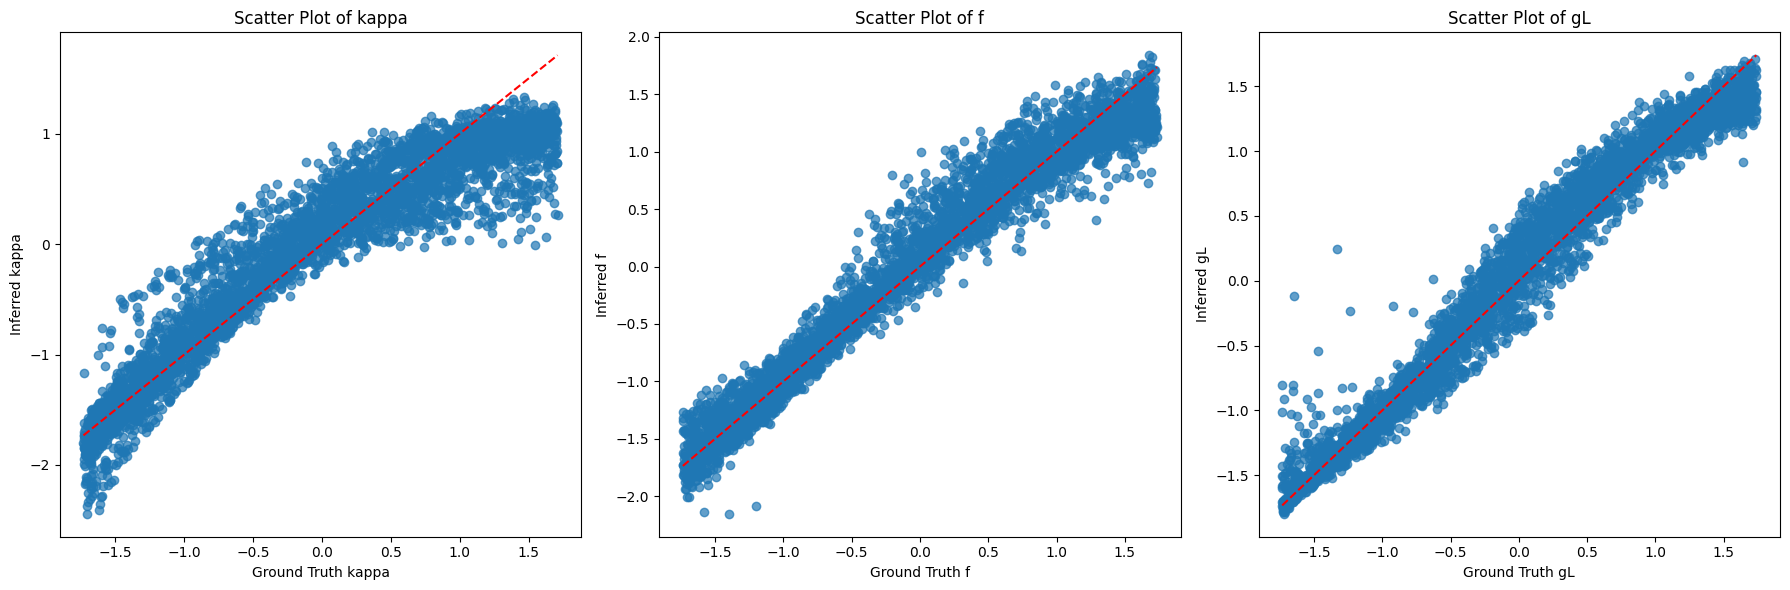

In [155]:
import matplotlib.pyplot as plt

# Initialize lists to store ground truth and inferred features
ground_truth_list = []
inferred_features_list = []

# Iterate through all batches in the dataloader
for batch_params, batch_features, batch_images in dataloader:
    # Iterate through each image and feature in the batch
    for i in range(batch_images.size(0)):
        test_image = batch_images[i].unsqueeze(0)  # Take the i-th image from the batch
        ground_truth = batch_features[i]  # Corresponding ground truth features

        # Infer features from the test image
        inferred_features = infer_feature(vae.encoder, converterL2F, test_image,
                                          images_mean, images_std,
                                          dataset.features_mean, dataset.features_std,
                                          device=device, denormalize=False)

        # Append to lists
        ground_truth_list.append(ground_truth.numpy())
        inferred_features_list.append(inferred_features.squeeze().numpy())

# Convert lists to numpy arrays
ground_truth_array = np.array(ground_truth_list)
inferred_features_array = np.array(inferred_features_list)

# Plot the scatter of inferred features and ground truth
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
feature_names = ['kappa', 'f', 'gL']
for i in range(3):
    axs[i].scatter(ground_truth_array[:, i], inferred_features_array[:, i], alpha=0.7)
    axs[i].set_xlabel(f'Ground Truth {feature_names[i]}')
    axs[i].set_ylabel(f'Inferred {feature_names[i]}')
    axs[i].set_title(f'Scatter Plot of {feature_names[i]}')
    axs[i].plot([ground_truth_array[:, i].min(), ground_truth_array[:, i].max()],
                [ground_truth_array[:, i].min(), ground_truth_array[:, i].max()], 'r--')

plt.tight_layout()
plt.show()

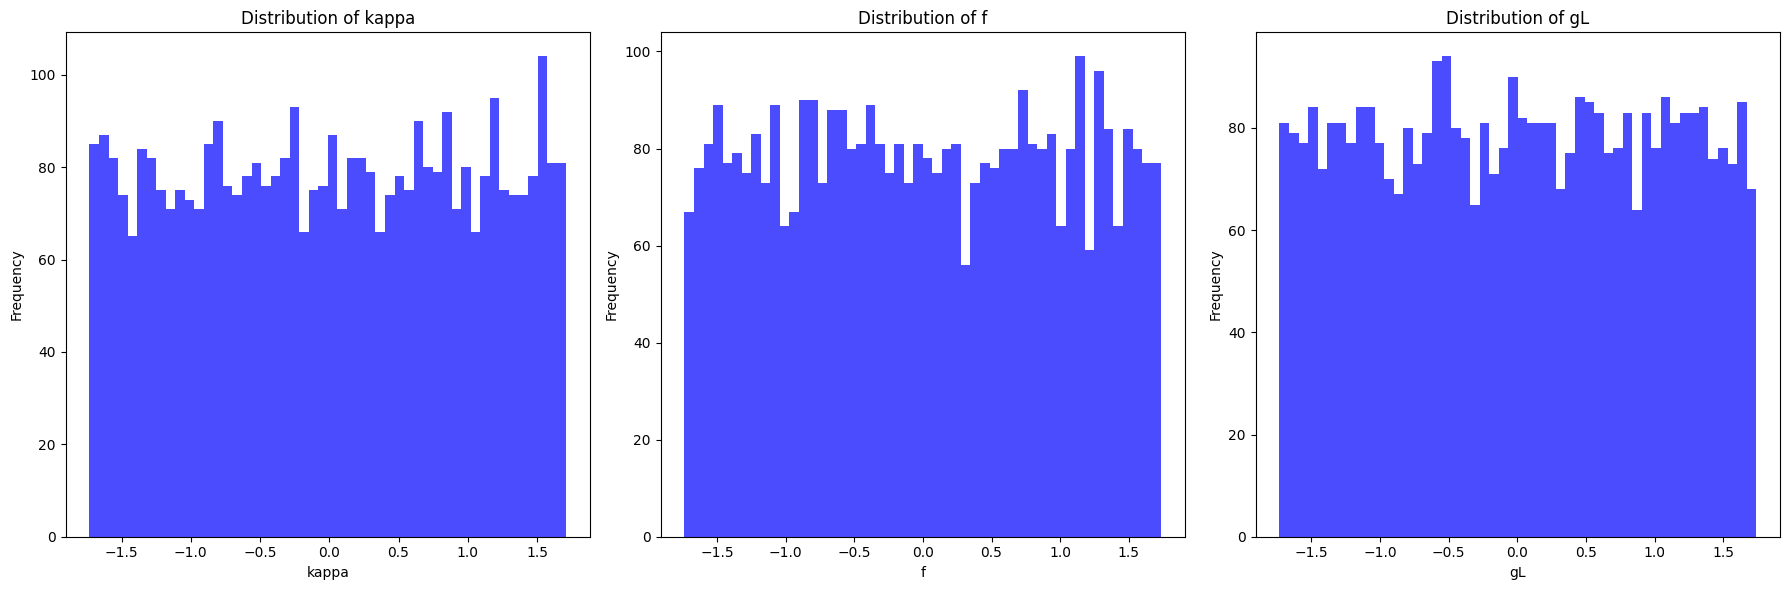

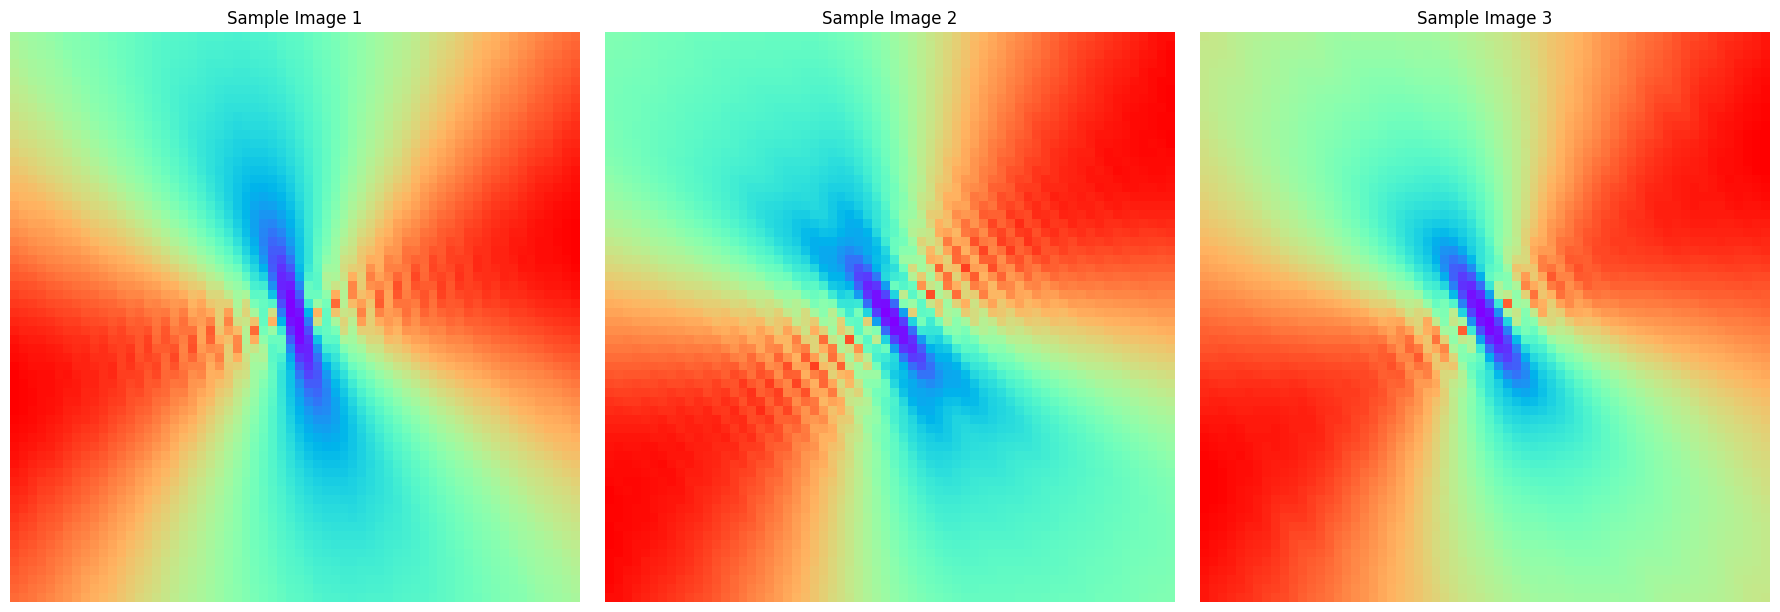

In [184]:
import numpy as np
import matplotlib.pyplot as plt

# Read data using dataloader
features_list = []
images_list = []
#folder = "../data/20240924_random"
folder = "../data/20250217" # 64x64 data, with additional qb1d line
L = 200
rand_num = 5500
rand_max = 4500
parameters = generate_parameter_list(folder, L, rand_num, rand_max)

batch_size = 32
dataloader, dataset = create_dataloader(folder, parameters, batch_size=batch_size, shuffle=True)

for features, images in dataloader:
    features_list.append(features.numpy())
    images_list.append(images.numpy())

# Convert lists to numpy arrays
features_np = np.concatenate(features_list, axis=0)  # shape: (N, 3)
images_np = np.concatenate(images_list, axis=0)      # shape: (N, 1, H, W)

# Plot the distribution of each polymer parameter.
feature_names = ['kappa', 'f', 'gL']
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for i in range(3):
    axs[i].hist(features_np[:, i], bins=50, alpha=0.7, color='blue')
    axs[i].set_title(f'Distribution of {feature_names[i]}')
    axs[i].set_xlabel(feature_names[i])
    axs[i].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

# Plot 3 sample images (denormalized if needed).
# Here we assume that the images are stored in normalized form (as produced by the dataset).
# If you want to see the original scale, you can optionally denormalize using dataset.images_mean and dataset.images_std.
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for i in range(3):
    # images_np[i, 0] is the i-th image (single channel)
    axs[i].imshow(images_np[i, 0].T, cmap='rainbow', origin='lower')
    axs[i].set_title(f'Sample Image {i+1}')
    axs[i].axis('off')
plt.tight_layout()
plt.show()


In [ ]:
#folder = "../data/20240924_random"
folder = "../data/20250217" # 64x64 data, with additional qb1d line
L = 200
rand_num = 5500
rand_max = 4500
parameters = generate_parameter_list(folder, L, rand_num, rand_max)

batch_size = 32
dataloader, dataset = create_dataloader(folder, parameters, batch_size=batch_size, shuffle=True)

# Automatically determine image size (nq) from the dataset.
sample_features, sample_images = next(iter(dataloader))
nq = sample_images.shape[-1]  # Assuming images are [B, 1, H, W] and square.
print("Detected image size:", nq, "x", nq)

# Set latent_dim to 3 so that the latent space corresponds to our three polymer parameters.
latent_dim = 3
vae = VAE(latent_dim, nq)
converter = Converter(latent_dim)

device = "cuda" if torch.cuda.is_available() else "cpu"

print("Training VAE...")
train_vae(vae, dataloader, num_epochs=50, lr=1e-3, device=device)

# Freeze the decoder for converter training.
pretrained_decoder = vae.decoder
pretrained_decoder.to(device)
for param in pretrained_decoder.parameters():
    param.requires_grad = False
pretrained_decoder.eval()

print("Training Converter...")
train_converter(converter, pretrained_decoder, dataloader, num_epochs=80, lr=1e-3, device=device)

# For generation, retrieve normalization stats from the dataset.
features_mean = dataset.features_mean  # shape: (3,)
features_std = dataset.features_std    # shape: (3,)
images_mean = dataset.images_mean      # scalar
images_std = dataset.images_std        # scalar

sample_params = torch.tensor([[0.8, 1.2, 0.5]], dtype=torch.float32)  # raw polymer parameters
generated_image = generate_scattering(converter, pretrained_decoder, sample_params,
                                      features_mean, features_std,
                                      images_mean, images_std,
                                      device=device)
print("Generated image shape:", generated_image.shape)  # Expected: [1, 1, nq, nq]


Detected image size: 64 x 64
Training VAE...
Epoch 1, Loss: 0.009232
Epoch 2, Loss: 0.000498
Epoch 3, Loss: 0.000264
Epoch 4, Loss: 0.000203
Epoch 5, Loss: 0.000183
Epoch 6, Loss: 0.000156
Epoch 7, Loss: 0.000176
Epoch 8, Loss: 0.000129
Epoch 9, Loss: 0.000133
Epoch 10, Loss: 0.000124
Epoch 11, Loss: 0.000117
Epoch 12, Loss: 0.000110
Epoch 13, Loss: 0.000122
Epoch 14, Loss: 0.000104
Epoch 15, Loss: 0.000105
Epoch 16, Loss: 0.000095
Epoch 17, Loss: 0.000101
Epoch 18, Loss: 0.000091
Epoch 19, Loss: 0.000091
Epoch 20, Loss: 0.000099
Epoch 21, Loss: 0.000085
Epoch 22, Loss: 0.000081
Epoch 23, Loss: 0.000090
Epoch 24, Loss: 0.000083
Epoch 25, Loss: 0.000076
Epoch 26, Loss: 0.000092
Epoch 27, Loss: 0.000071
Epoch 28, Loss: 0.000073
Epoch 29, Loss: 0.000079
Epoch 30, Loss: 0.000066
Epoch 31, Loss: 0.000068
Epoch 32, Loss: 0.000064
Epoch 33, Loss: 0.000080
Epoch 34, Loss: 0.000062
Epoch 35, Loss: 0.000060
Epoch 36, Loss: 0.000068
Epoch 37, Loss: 0.000056
Epoch 38, Loss: 0.000059
Epoch 39, Loss

In [187]:
# continue training converter as needed
# Freeze the decoder (already frozen inside train_converter, but do it once more for clarity)

pretrained_decoder = vae.decoder
pretrained_decoder.to(device)
for param in pretrained_decoder.parameters():
    param.requires_grad = False
pretrained_decoder.eval()

print("Training Converter...")
train_converter(converter, pretrained_decoder, dataloader, num_epochs=20, lr=1e-3, device=device)


Training Converter...
[Converter] Epoch 1, Loss: 0.002603
[Converter] Epoch 2, Loss: 0.002597
[Converter] Epoch 3, Loss: 0.002593
[Converter] Epoch 4, Loss: 0.002581
[Converter] Epoch 5, Loss: 0.002575
[Converter] Epoch 6, Loss: 0.002567
[Converter] Epoch 7, Loss: 0.002553
[Converter] Epoch 8, Loss: 0.002549
[Converter] Epoch 9, Loss: 0.002542
[Converter] Epoch 10, Loss: 0.002550
[Converter] Epoch 11, Loss: 0.002539
[Converter] Epoch 12, Loss: 0.002524
[Converter] Epoch 13, Loss: 0.002516
[Converter] Epoch 14, Loss: 0.002516
[Converter] Epoch 15, Loss: 0.002507
[Converter] Epoch 16, Loss: 0.002527
[Converter] Epoch 17, Loss: 0.002495
[Converter] Epoch 18, Loss: 0.002502
[Converter] Epoch 19, Loss: 0.002489
[Converter] Epoch 20, Loss: 0.002504


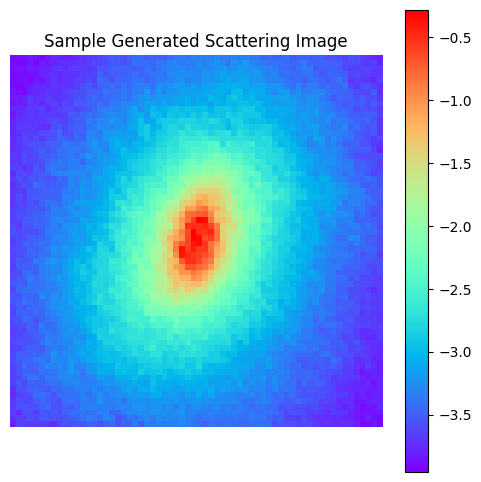

In [195]:
import matplotlib.pyplot as plt
sample_params = torch.tensor([[15, 0.0, 0.0]], dtype=torch.float32)  # raw polymer parameters)
generated_image = generate_scattering(converter, pretrained_decoder, sample_params,
                                      features_mean, features_std,
                                      images_mean, images_std,
                                      device=device)
# Convert tensor to numpy array and plot the first generated image.
plt.figure(figsize=(6,6))
plt.imshow(-generated_image[0, 0].cpu().numpy().T, cmap='rainbow', origin='lower')
plt.title("Sample Generated Scattering Image")
plt.colorbar()
plt.axis('off')
plt.show()


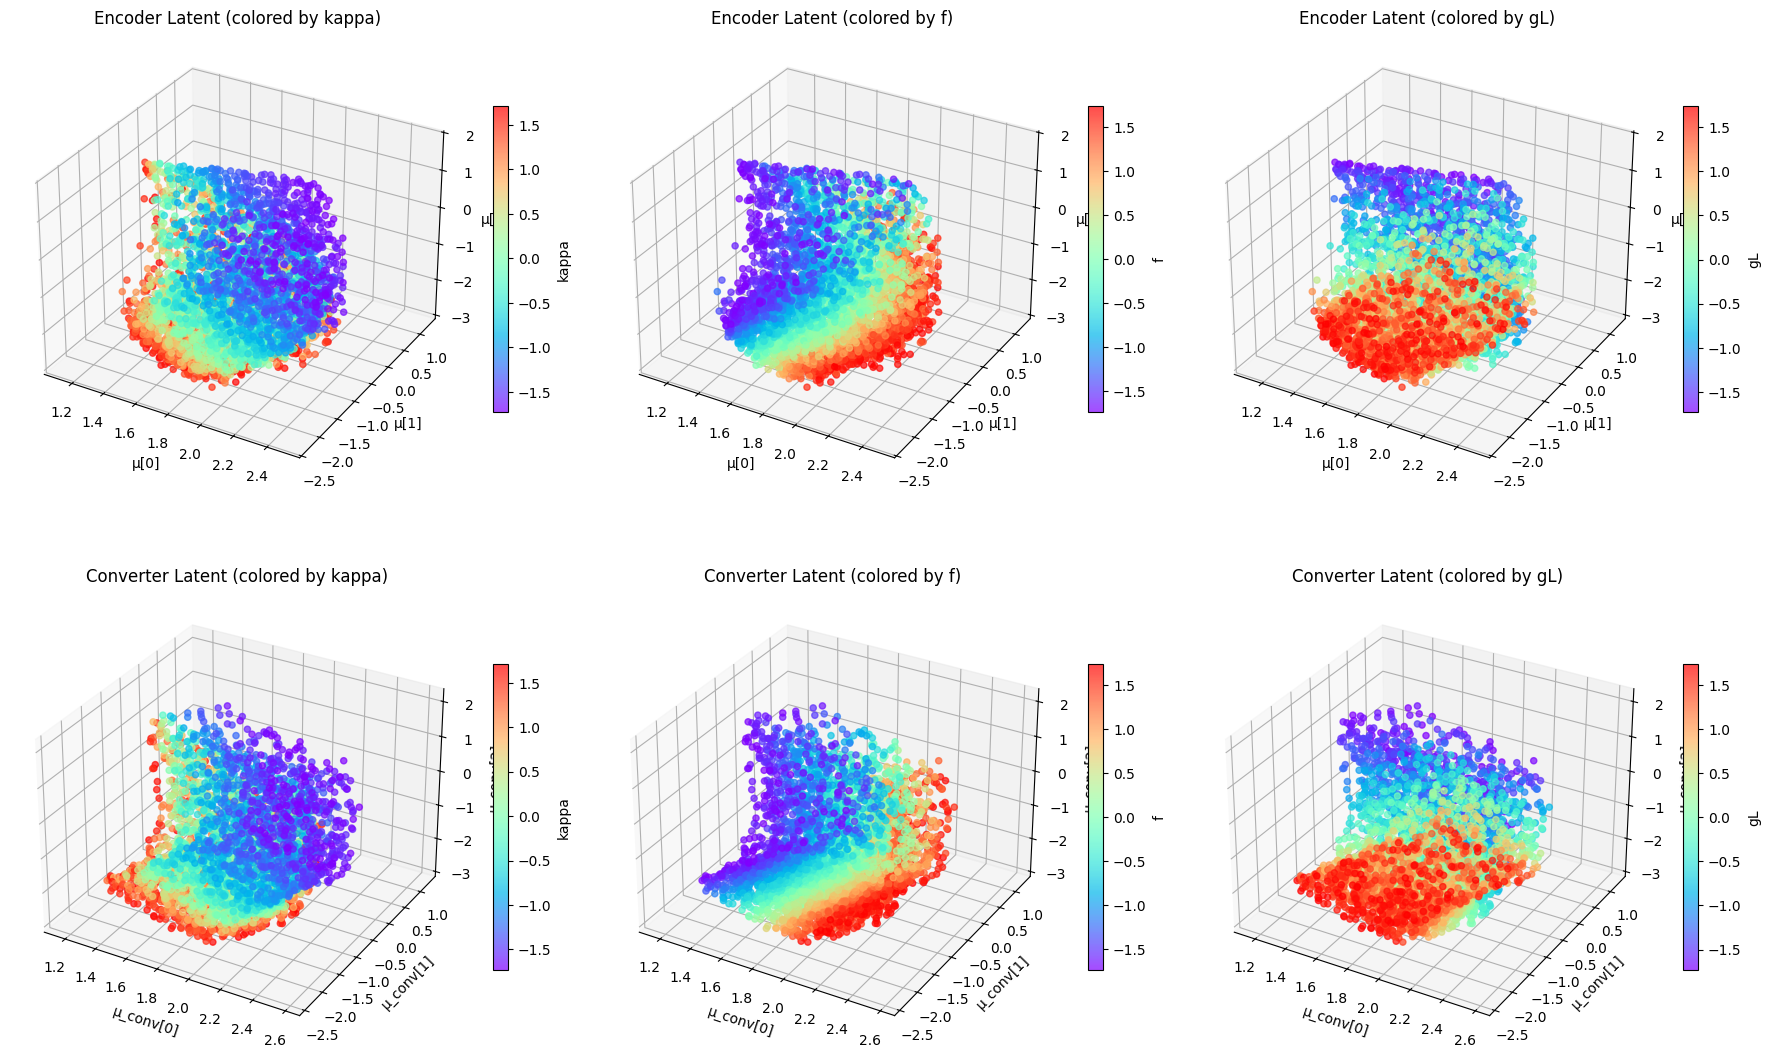

In [196]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting
import numpy as np

# Aggregate latent representations from both the VAE encoder and the Converter.
all_mu_encoder = []    # Latent μ from VAE encoder.
all_mu_converter = []  # Latent μ from Converter.
all_features = []      # Polymer parameters (for coloring).

vae.eval()
converter.eval()
with torch.no_grad():
    for features, images in dataloader:
        images = images.to(device)
        # Get latent μ from the encoder.
        mu, _ = vae.encoder(images)  # shape: [batch, latent_dim]
        all_mu_encoder.append(mu.detach().cpu().numpy())

        # Get converter output, which now returns (z, μ, logvar).
        features_device = features.to(device)
        _, mu_conv, _ = converter(features_device)  # shape: [batch, latent_dim]
        all_mu_converter.append(mu_conv.detach().cpu().numpy())

        all_features.append(features.detach().cpu().numpy())

# Concatenate arrays across batches.
all_mu_encoder = np.concatenate(all_mu_encoder, axis=0)    # Shape: [N, 3]
all_mu_converter = np.concatenate(all_mu_converter, axis=0)  # Shape: [N, 3]
all_features = np.concatenate(all_features, axis=0)          # Shape: [N, 3]

# Define feature names for coloring.
feature_names = ['kappa', 'f', 'gL']

# Create a 2x3 grid of subplots.
fig, axs = plt.subplots(2, 3, figsize=(18, 12), subplot_kw={'projection': '3d'})

# Top row: latent μ from the VAE encoder.
for i in range(3):
    sc = axs[0, i].scatter(all_mu_encoder[:, 0], all_mu_encoder[:, 1], all_mu_encoder[:, 2],
                           c=all_features[:, i], cmap='rainbow', alpha=0.7)
    axs[0, i].set_xlabel('μ[0]')
    axs[0, i].set_ylabel('μ[1]')
    axs[0, i].set_zlabel('μ[2]')
    axs[0, i].set_title(f'Encoder Latent (colored by {feature_names[i]})')
    fig.colorbar(sc, ax=axs[0, i], shrink=0.5, label=feature_names[i])

# Bottom row: latent μ from the Converter.
for i in range(3):
    sc = axs[1, i].scatter(all_mu_converter[:, 0], all_mu_converter[:, 1], all_mu_converter[:, 2],
                           c=all_features[:, i], cmap='rainbow', alpha=0.7)
    axs[1, i].set_xlabel('μ_conv[0]')
    axs[1, i].set_ylabel('μ_conv[1]')
    axs[1, i].set_zlabel('μ_conv[2]')
    axs[1, i].set_title(f'Converter Latent (colored by {feature_names[i]})')
    fig.colorbar(sc, ax=axs[1, i], shrink=0.5, label=feature_names[i])

plt.tight_layout()
plt.show()


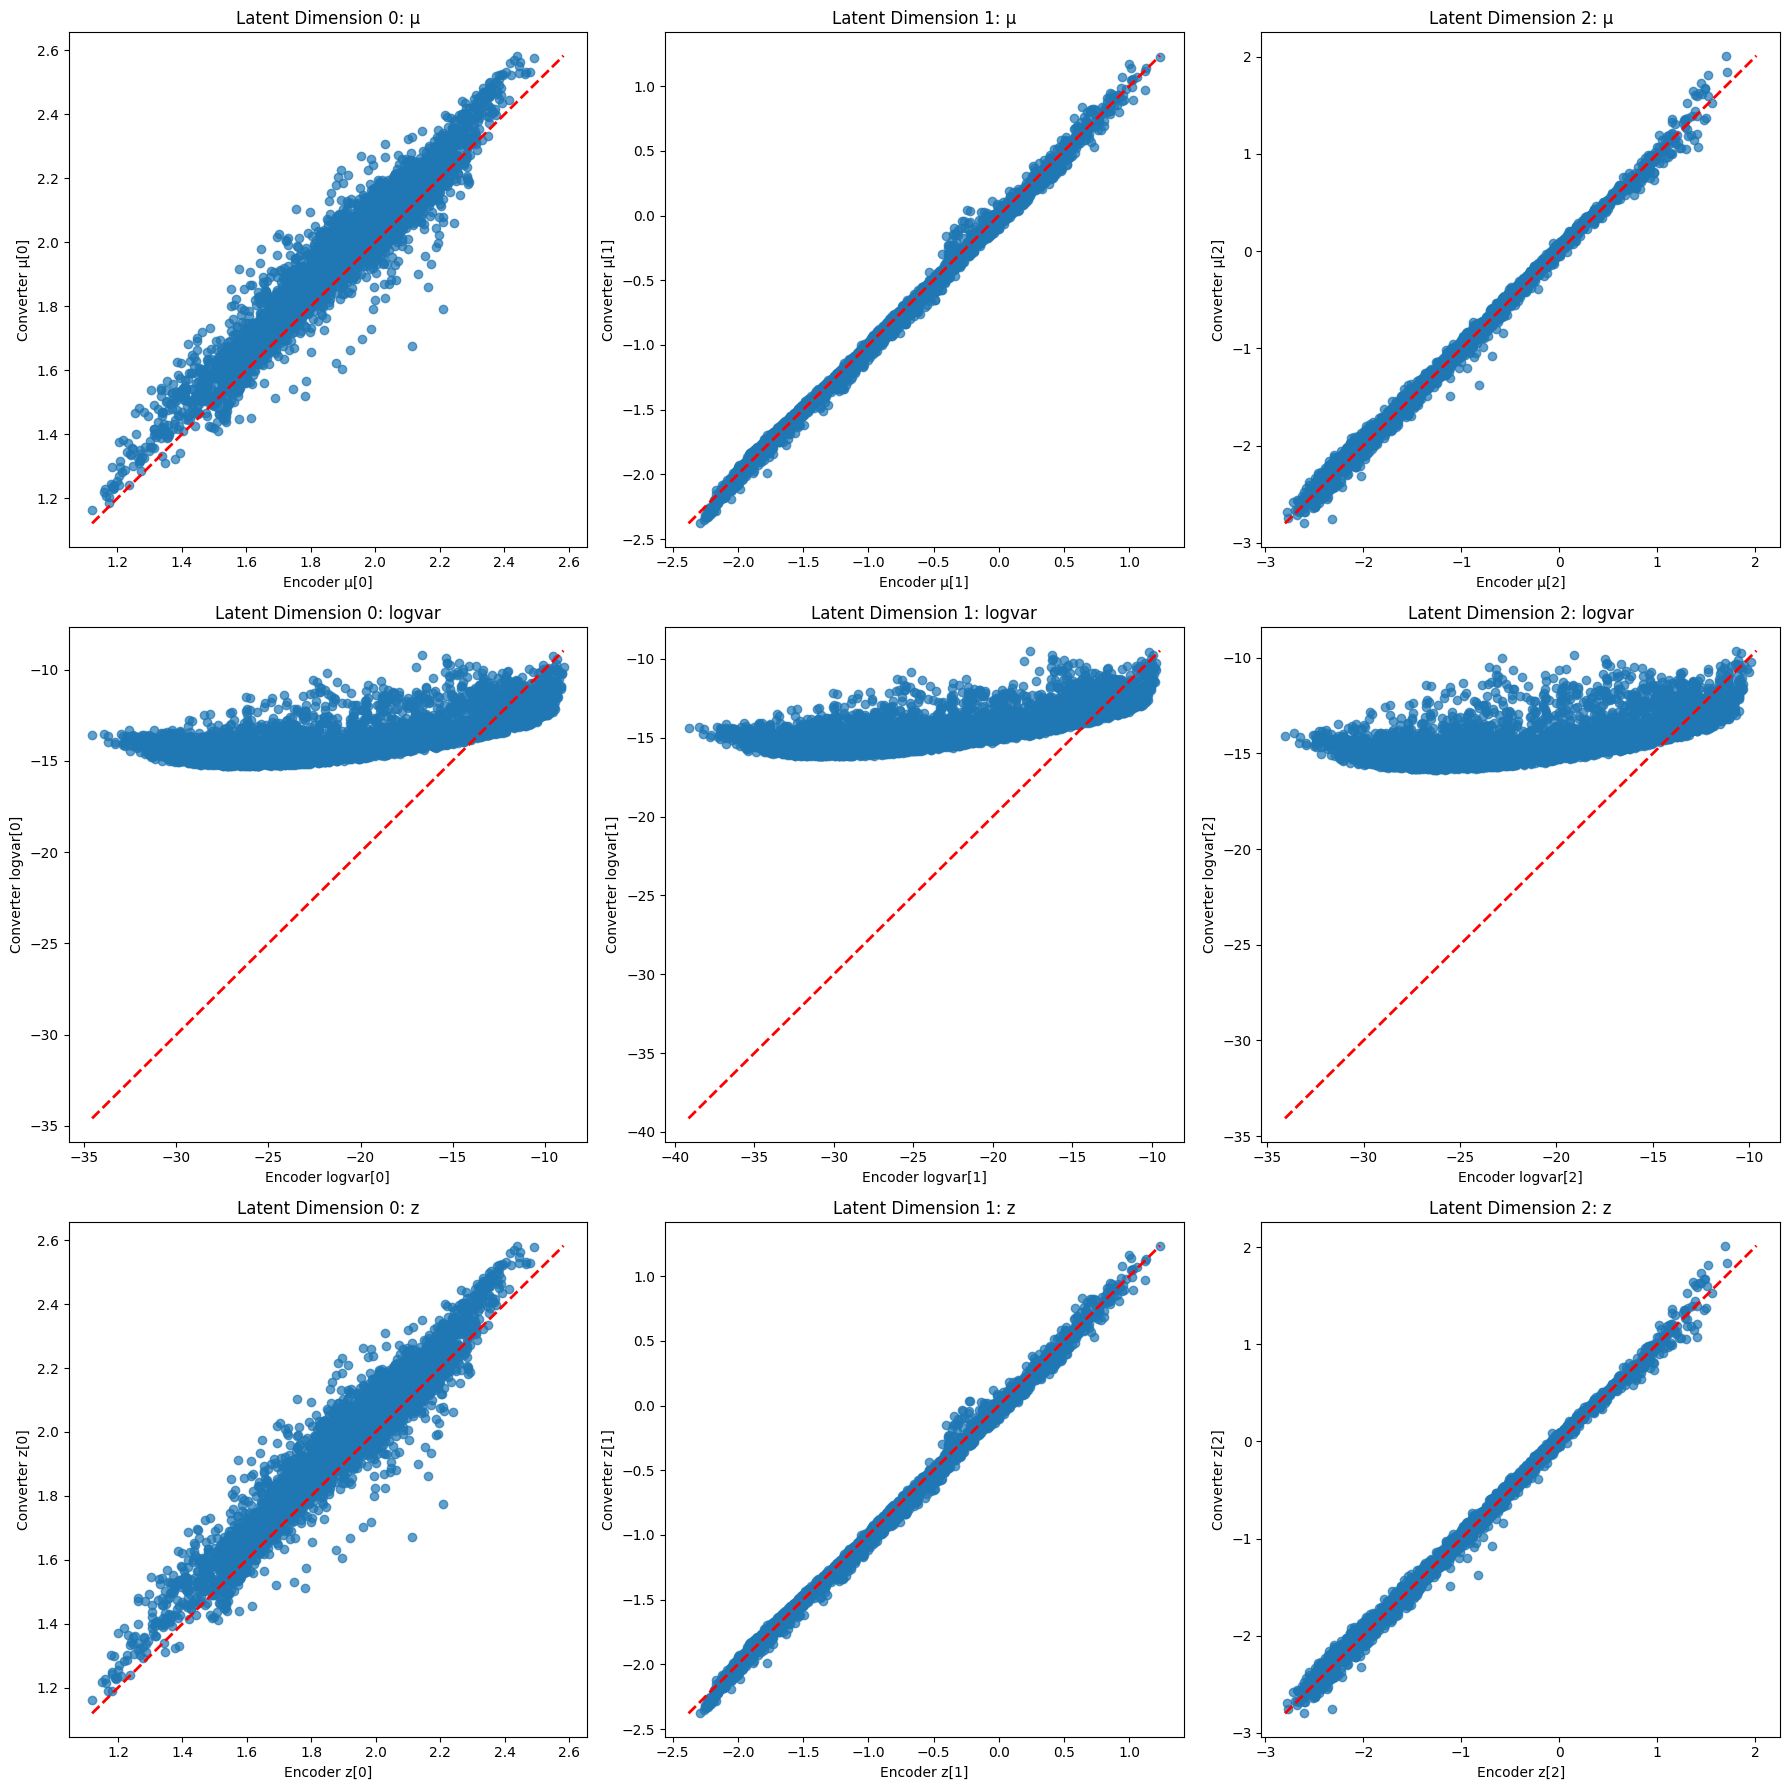

In [197]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting (if needed)
import numpy as np

# Aggregate latent representations from both the VAE encoder and the Converter.
all_mu_encoder = []       # Encoder's μ
all_logvar_encoder = []   # Encoder's logvar
all_z_encoder = []        # Encoder's z (via reparameterization)

all_mu_conv = []          # Converter's μ output
all_logvar_conv = []      # Converter's logvar output
all_z_conv = []           # Converter's z output

all_features = []         # Polymer parameters (for reference)

vae.eval()
converter.eval()
with torch.no_grad():
    for features, images in dataloader:
        images = images.to(device)
        # Get encoder outputs.
        mu_enc, logvar_enc = vae.encoder(images)
        z_enc = vae.reparameterize(mu_enc, logvar_enc)
        all_mu_encoder.append(mu_enc.detach().cpu().numpy())
        all_logvar_encoder.append(logvar_enc.detach().cpu().numpy())
        all_z_encoder.append(z_enc.detach().cpu().numpy())

        # Get converter outputs using polymer parameters.
        features_device = features.to(device)
        z_conv, mu_conv, logvar_conv = converter(features_device)
        all_mu_conv.append(mu_conv.detach().cpu().numpy())
        all_logvar_conv.append(logvar_conv.detach().cpu().numpy())
        all_z_conv.append(z_conv.detach().cpu().numpy())

        all_features.append(features.detach().cpu().numpy())

all_mu_encoder = np.concatenate(all_mu_encoder, axis=0)        # [N, latent_dim]
all_logvar_encoder = np.concatenate(all_logvar_encoder, axis=0)    # [N, latent_dim]
all_z_encoder = np.concatenate(all_z_encoder, axis=0)              # [N, latent_dim]

all_mu_conv = np.concatenate(all_mu_conv, axis=0)                  # [N, latent_dim]
all_logvar_conv = np.concatenate(all_logvar_conv, axis=0)          # [N, latent_dim]
all_z_conv = np.concatenate(all_z_conv, axis=0)                    # [N, latent_dim]

all_features = np.concatenate(all_features, axis=0)                # [N, 3]

# For each latent dimension, we will compare:
# - Encoder μ vs Converter μ,
# - Encoder logvar vs Converter logvar,
# - Encoder z vs Converter z.

fig, axs = plt.subplots(3, 3, figsize=(18, 18))
representation_names = ['μ', 'logvar', 'z']

for dim in range(latent_dim):  # for each latent dimension (0,1,2)
    # Row 0: Compare encoder μ vs. converter μ.
    axs[0, dim].scatter(all_mu_encoder[:, dim], all_mu_conv[:, dim], alpha=0.7)
    mn = min(all_mu_encoder[:, dim].min(), all_mu_conv[:, dim].min())
    mx = max(all_mu_encoder[:, dim].max(), all_mu_conv[:, dim].max())
    axs[0, dim].plot([mn, mx], [mn, mx], 'r--', linewidth=2)
    axs[0, dim].set_xlabel(f'Encoder {representation_names[0]}[{dim}]')
    axs[0, dim].set_ylabel(f'Converter {representation_names[0]}[{dim}]')
    axs[0, dim].set_title(f'Latent Dimension {dim}: {representation_names[0]}')

    # Row 1: Compare encoder logvar vs. converter logvar.
    axs[1, dim].scatter(all_logvar_encoder[:, dim], all_logvar_conv[:, dim], alpha=0.7)
    mn = min(all_logvar_encoder[:, dim].min(), all_logvar_conv[:, dim].min())
    mx = max(all_logvar_encoder[:, dim].max(), all_logvar_conv[:, dim].max())
    axs[1, dim].plot([mn, mx], [mn, mx], 'r--', linewidth=2)
    axs[1, dim].set_xlabel(f'Encoder {representation_names[1]}[{dim}]')
    axs[1, dim].set_ylabel(f'Converter {representation_names[1]}[{dim}]')
    axs[1, dim].set_title(f'Latent Dimension {dim}: {representation_names[1]}')

    # Row 2: Compare encoder z vs. converter z.
    axs[2, dim].scatter(all_z_encoder[:, dim], all_z_conv[:, dim], alpha=0.7)
    mn = min(all_z_encoder[:, dim].min(), all_z_conv[:, dim].min())
    mx = max(all_z_encoder[:, dim].max(), all_z_conv[:, dim].max())
    axs[2, dim].plot([mn, mx], [mn, mx], 'r--', linewidth=2)
    axs[2, dim].set_xlabel(f'Encoder {representation_names[2]}[{dim}]')
    axs[2, dim].set_ylabel(f'Converter {representation_names[2]}[{dim}]')
    axs[2, dim].set_title(f'Latent Dimension {dim}: {representation_names[2]}')

plt.tight_layout()
plt.show()
